<a href="https://colab.research.google.com/github/ShaominXu/Deep-Learning-Labs/blob/main/Implementing%20back-propagation%20in%20Python%20from%20scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this problem we will train a neural network from scratch using numpy. In practice, you will never need to do this (you'd just use TensorFlow or PyTorch). But hopefully this will give us a sense of what's happening under the hood.

For training/testing, we will use the standard MNIST benchmark consisting of images of handwritten images.



11490434/11490434 [==============================] - 0s 0us/step


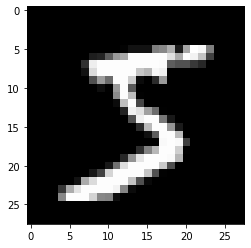

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data(path="mnist.npz")

plt.imshow(x_train[0],cmap='gray');

Loading MNIST is the only place where we will use TensorFlow; the rest of the code will be pure numpy.

Let us now set up a few helper functions. We will use sigmoid activations for neurons, the softmax activation for the last layer, and the cross entropy loss.

In [ ]:
import numpy as np

def sigmoid(x):
  # Numerically stable sigmoid function based on
  # http://timvieira.github.io/blog/post/2014/02/11/exp-normalize-trick/

  x = np.clip(x, -500, 500) # We get an overflow warning without this

  return np.where(
    x >= 0,
    1 / (1 + np.exp(-x)),
    np.exp(x) / (1 + np.exp(x))
  )

def dsigmoid(x): # Derivative of sigmoid
  return sigmoid(x) * (1 - sigmoid(x))

def softmax(x):
  # Numerically stable softmax based on (same source as sigmoid)
  # http://timvieira.github.io/blog/post/2014/02/11/exp-normalize-trick/
  b = x.max()
  y = np.exp(x - b)
  return y / y.sum()

def cross_entropy_loss(y, yHat):
  return -np.sum(y * np.log(yHat))

def integer_to_one_hot(x, max):
  # x: integer to convert to one hot encoding
  # max: the size of the one hot encoded array
  result = np.zeros(10)
  result[x] = 1
  return result

OK, we are now ready to build and train our model. The input is an image of size 28x28, and the output is one of 10 classes. So, first:

Q1. Initialize a 2-hidden layer neural network with 32 neurons in each hidden layer, i.e., your layer sizes should be:

784 -> 32 -> 32 -> 10

If the layer is $n_{in} \times n_{out}$ your layer weights should be initialized by sampling from a normal distribution with mean zero and variance 1/$\max(n_{in},n_{out})$.

In [ ]:
import math

# Initialize weights of each layer with a normal distribution of mean 0 and
# standard deviation 1/sqrt(n), where n is the number of inputs.
# This means the weighted input will be a random variable itself with mean
# 0 and standard deviation close to 1 (if biases are initialized as 0, standard
# deviation will be exactly 1)

from numpy.random import default_rng

rng = default_rng(80085)

# Q1. Fill initialization code here.

LayerSizes = [784, 32, 32, 10]
Weights1 = rng.normal(0,1/np.sqrt(LayerSizes[0]),size=(LayerSizes[0],LayerSizes[1]))
Weights2 = rng.normal(0,1/np.sqrt(LayerSizes[1]),size=(LayerSizes[1],LayerSizes[2]))
Weights3 = rng.normal(0,1/np.sqrt(LayerSizes[2]),size=(LayerSizes[2],LayerSizes[3]))

Biases1 = np.zeros((1,LayerSizes[1]))
Biases2 = np.zeros((1,LayerSizes[2]))
Biases3 = np.zeros((1,LayerSizes[3]))

#weights = [Weights1,Weights2,Weights3]
biases = [Biases1,Biases2,Biases3]

weights = [
 rng.normal(0, 1/math.sqrt(784), (32, 784)),
 rng.normal(0, 1/math.sqrt(32), (32, 32)),
 rng.normal(0, 1/math.sqrt(32), (10, 32))
]


Next, we will set up the forward pass. We will implement this by looping over the layers and successively computing the activations of each layer.

Q2. Implement the forward pass for a single sample, and for the entire dataset.


Right now, your network weights should be random, so doing a forward pass with the data should not give you any meaningful information. Therefore, in the last line, when you calculate test accuracy, it should be somewhere around 1/10 (i.e., a random guess).

In [ ]:
def feed_forward_sample(sample, y):
  """ Forward pass through the neural network.
    Inputs:
      sample: 1D numpy array. The input sample (an MNIST digit).
      label: An integer from 0 to 9.

    Returns: the cross entropy loss, most likely class
  """
  # Q2. Fill code here.
  # ...
  numclasses = 10
  u1 = np.dot(sample,weights[0]) + biases[0]
  z1 = sigmoid(u1)
  u2 = np.dot(z1,weights[1]) + biases[1]
  z2 = sigmoid(u2)
  u3 = np.dot(z2,weights[2]) + biases[2]
  yhat = softmax(u3)
  pred = np.argmax(yhat)
  one_hot_guess = integer_to_one_hot(pred,numclasses)

  yvector = integer_to_one_hot(y,numclasses)
  loss = cross_entropy_loss(yvector,yhat)

  return loss, one_hot_guess


def feed_forward_dataset(x, y):
  losses = np.empty(x.shape[0])
  one_hot_guesses = np.empty((x.shape[0], 10))

  for i in range(x.shape[0]):
    sample = np.reshape(x[i],(1,784))
    [loss_sample,one_hot_guess_sample] = feed_forward_sample(sample,y[i])
    losses[i] = loss_sample
    one_hot_guesses[i] = one_hot_guess_sample

  y_one_hot = np.zeros((y.size, 10))
  y_one_hot[np.arange(y.size), y] = 1

  correct_guesses = np.sum(y_one_hot * one_hot_guesses)
  correct_guess_percent = format((correct_guesses / y.shape[0]) * 100, ".2f")

  print("\nAverage loss:", np.round(np.average(losses), decimals=2))
  print("Accuracy (# of correct guesses):", correct_guesses, "/", y.shape[0], "(", correct_guess_percent, "%)")

def feed_forward_training_data():
  print("Feeding forward all training data...")
  feed_forward_dataset(x_train, y_train)
  print("")

def feed_forward_test_data():
  print("Feeding forward all test data...")
  feed_forward_dataset(x_test, y_test)
  print("")

feed_forward_test_data()

Feeding forward all test data...


ValueError: ignored

OK, now we will implement the backward pass using backpropagation. We will keep it simple and just do training sample-by-sample (no minibatching, no randomness).

Q3: Compute the gradient of all the weights and biases by backpropagating derivatives all the way from the output to the first layer.





In [ ]:
def train_one_sample(sample, y, learning_rate=0.003):
  a = np.reshape(sample,(1,28*28))

  # We will store each layer's activations to calculate gradient
  activations = []
  num_layers = 3
  weight_gradients = []
  bias_gradients = []

  # Forward pass
  # (same as what we did above, but keep track of intermediate activations)

  numclasses = 10
  u1 = np.dot(a,weights[0]) + biases[0]
  z1 = sigmoid(u1)
  activations.append(z1)
  u2 = np.dot(z1,weights[1]) + biases[1]
  z2 = sigmoid(u2)
  activations.append(z2)
  u3 = np.dot(z2,weights[2]) + biases[2]
  yhat = softmax(u3)
  activations.append(yhat)
  pred = np.argmax(yhat)
  one_hot_guess = integer_to_one_hot(pred,numclasses)
  yvector = integer_to_one_hot(y,numclasses)
  loss = cross_entropy_loss(yvector,yhat)

  # Backward pass
  du3 = activations[2]-yvector #a[2]=y_hat
  # dL_dW3 = du3_dW3*dL_du3
  dW3 = activations[1].T.dot(du3) #a[1]=z2 # dL_db3 = du3_db3*dL_du3
  db3 = du3
  # dL_dz2 = dL_du3*du3_dz2
  dz2 = du3.dot(weights[2].T)
  # dL_dW2 = dz2_dW2*dL_dz2
  dW2 = activations[0].T.dot(np.multiply(dz2,dsigmoid(u2))) #a[0] = z1 # dL_db2 = dz2_db2*dL_dz2
  db2 = np.multiply(dz2,dsigmoid(u2))
  # dL_dz1 = dL_dz2*dz2_dz1
  dz1 = np.multiply(dz2.dot(weights[1].T),dsigmoid(u2))
  # dz1_dW1 = dL_dz1*dz1_dW1
  dW1 = a.T.dot(np.multiply(dz1,dsigmoid(u1)))
  # dz1_db1 = dL_dz1*dz1_db1
  db1 = np.multiply(dz1,dsigmoid(u1))

  # Assemble gradients
  weight_gradients.append(dW1)
  weight_gradients.append(dW2)
  weight_gradients.append(dW3)
  bias_gradients.append(db1)
  bias_gradients.append(db2)
  bias_gradients.append(db3)

  # Update weights & biases based on your calculated gradient
  for i in range(num_layers):
    weights[i] -= weight_gradients[i] * learning_rate
    biases[i] -= bias_gradients[i].flatten() * learning_rate



Finally, train for 3 epochs by looping over the entire training dataset 3 times.

Q4. Train your model for 3 epochs.

In [ ]:
def train_one_epoch(learning_rate=0.005):
  print("Training for one epoch over the training dataset...")

  for i in range(x_train.shape[0]):
    train_one_sample(x_train[i], y_train[i], learning_rate)

  print("Finished training.\n")


feed_forward_test_data()

def test_and_train():
  train_one_epoch()
  feed_forward_test_data()

for i in range(3):
  test_and_train()

Feeding forward all test data...

Average loss: 2.37
Accuracy (# of correct guesses): 880.0 / 10000 ( 8.80 %)

Training for one epoch over the training dataset...
Finished training.

Feeding forward all test data...

Average loss: 1.21
Accuracy (# of correct guesses): 5488.0 / 10000 ( 54.88 %)

Training for one epoch over the training dataset...
Finished training.

Feeding forward all test data...

Average loss: 1.22
Accuracy (# of correct guesses): 5791.0 / 10000 ( 57.91 %)

Training for one epoch over the training dataset...
Finished training.

Feeding forward all test data...

Average loss: 1.2
Accuracy (# of correct guesses): 5754.0 / 10000 ( 57.54 %)




That's it!

Your code is probably very time- and memory-inefficient; that's ok. There is a ton of optimization under the hood in professional deep learning frameworks which we won't get into.

If everything is working well, you should be able to raise the accuracy from ~10% to ~70% accuracy after 3 epochs.